# Implementing Random Forest 

In [1]:
import numpy as np
import math 
%matplotlib inline
import matplotlib.pyplot as plt

### Regression Tree  

In [2]:
class decisionTree:
    def __init__(self,data,index,h):
        if h==0:
            self.leaf = True
            self.prediction = self.average(data,index)
        elif len( set([data[i][-1] for i in index]) ) == 1:
            self.leaf = True
            self.prediction = data[index[0]][-1]
       
        else:
            self.leaf = False
            self.attr , self.split , self.left , self.right = self.generate(data,index,h)

    def average(self,data,index):
        if len(index) == 0: 
            return 0.0
        return sum([ data[i][-1] for i in index ]) / len(index)

    def rss(self,data,index):
        if len(index) == 0:
            return 0.0
        mean = self.average(data,index)
        return sum([ pow( data[i][-1]-mean , 2.0 ) for i in index ])
  

    def generate(self,data,index,h):
        p = len(data[index[0]])-1
        labels = [ data[i][-1] for i in index ]
        
        opt = pow ( max(labels) - min(labels) , 2.0 ) * len(index) + 1.0
       
        random_attr=np.random.choice(p,math.ceil(p/3),replace=False)
        
        for j in random_attr:
            cuts = set( [ data[i][j] for i in index ] )
            for cut in cuts:
                yl = [ i for i in index if data[i][j]<=cut ]
                yr = [ i for i in index if data[i][j]>cut ]
                tp = self.rss(data,yl) + self.rss(data,yr)
                if tp < opt:
                    opt , attr ,split, left , right = tp , j , cut , yl , yr
        return attr , split , decisionTree(data,left,h-1) , decisionTree(data,right,h-1)

    def predict(self,x):
        if self.leaf == True: 
            return self.prediction
        if (x[self.attr] <= self.split): 
            return self.left.predict(x)
        return self.right.predict(x)

   

### Uploading and splitting the dataset 

In [3]:
#importing the dataset
from sklearn.datasets import load_boston
boston=load_boston()
data=boston.data
data=np.c_[data,boston.target]


c:\Users\ferna\programs inst\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np

        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing datase

In [4]:
#splitting the dataset into training and test set 
from sklearn.model_selection import train_test_split
data_train, data_test= train_test_split(data,test_size=0.3, random_state=2802)


### Creating the function 'bts'  to generate the B BTS and the function 'trees' that would call the function 'bts' and will train B regression trees from the BTS samples.

In [5]:
#This is a function that would generate the B BTS from the training set 
def bts(data,B):
    number_of_rows = data.shape[0]
    samples=[]
    for i in range(B):
        random_indices = np.random.choice(number_of_rows, size=number_of_rows, replace=True)
        random_rows = data[random_indices, :]
        samples.append(random_rows)
    return samples 

#This is a function that will call the bts function that will generate B BTS and then from those 
#samples will create B trees.

def trees(data,B,h):
    samples=bts(data,B)
    trees=[]
    for i in range(B):
        data=samples[i]
        index=[j for j in range(len(data))]
        trees.append(decisionTree(data,index,h))
    return trees



### Creating the function 'y_pred'  that would predict the labels. One y_hat for each tree and then calculate the final y_hat for each observation.

In [36]:

def y_pred(data,list_trees):
    y_hat_list=[] #list of lists with predictions for each observation for each tree
    for i in range(len(list_trees)):
        y_hat_list.append([list_trees[i].predict(data[j]) for j in range(len(data))])
    #calculating the mean prediction for each observation 
    y_hat_list=np.array(y_hat_list)
    index=len(y_hat_list[0,:])
    y_hat=[np.mean(y_hat_list[:,i]) for i in range(index)]
    
    return y_hat



### Defining the function 'mse' that will call the function 'y_pred' to calculate the predicted labels and then will calculate the mse for the dataset passed.

In [29]:
def mse(data,list_trees):
    y_hat=y_pred(data,list_trees)
    y=data[:,-1]
    mse=np.mean((y-y_hat)**2)
    return mse

### Calling all the functions to generate B=100 BTS samples, train B=100 decision trees from those samples with height=3, calculating the predicted labels and getting the mse for the training and test dataset.


In [37]:
B=100
h=3
list_trees=trees(data_train,B,h)
#training mse
mse_train= mse(data_train,list_trees)
#testing mse
mse_test=mse(data_test,list_trees)
print('The MSE for the training dataset is: {}'.format(mse_train))
print('The MSE for the test dataset is: {}'.format(mse_test))


The MSE for the training dataset is: 12.289473548061117
The MSE for the test dataset is: 17.485571331535528


100

### Trying different values for the number of BTS (B) and plotting the training and test MSE against B

In [38]:
h=3
B=[10,20,30,50,80,100,120]
mse_train=[]
mse_test=[]
for i in B:
    list_trees=trees(data_train,i,h)
    mse_train.append(mse(data_train,list_trees))
    mse_test.append(mse(data_test,list_trees))
      

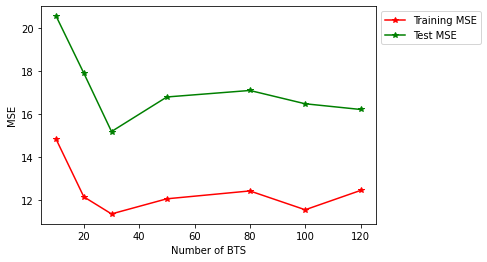

In [39]:
plt.plot(B,mse_train,'r*-',label='Training MSE')
plt.plot(B,mse_test,'g*-',label='Test MSE')    
plt.xlabel('Number of BTS')
plt.ylabel('MSE')
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')

plt.show()

### Trying different values for height (h) and plotting  training and test MSE against height

In [47]:
B=100 
h=[1,2,3,4]
mse_train=[]
mse_test=[]
for i in range(len(h)):
    list_trees=trees(data_train,B,h[i])
    mse_train.append(mse(data_train,list_trees))
    mse_test.append(mse(data_test,list_trees))
    

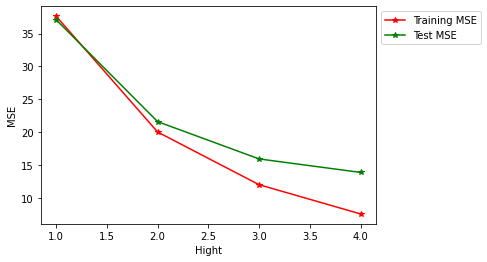

In [48]:
plt.plot(h,mse_train,'r*-',label='Training MSE')
plt.plot(h,mse_test,'g*-',label='Test MSE')    
plt.xlabel('Hight')
plt.ylabel('MSE')
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
